In [1]:
from itertools import islice

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from pytorch_lightning.loggers import CSVLogger
from datasets import load_dataset

from estimator import LagTransformerEstimator


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 122
CUDA SETUP: Loading binary /home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/libbitsandbytes_cuda122.so...


/home/kashif/.env/pytorch/lib/python3.10/site-packages/bitsandbytes-0.40.0.post4-py3.10.egg/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


[2023-07-28 14:41:24,712] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [4]:
dataset = get_dataset("electricity")

In [36]:
estimator = LagTransformerEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length,
    
    scaling="std",
    
    nhead=2,
    num_encoder_layers=4,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",
    
    batch_size=256,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=50),
    
)

In [37]:
predictor = estimator.train(
        training_data=dataset.train,
        shuffle_buffer_length=1024,
        cache_data=True,
    )

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because self.layers[0].norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LagTransformerModel | 109 K 
----------------------------------------------
44.1 K    Tra

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 5.89754 (best 5.89754), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_26/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.48680 (best 5.48680), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_26/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.35501 (best 5.35501), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_26/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.21553 (best 5.21553), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_26/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' was not in top 1
Epoch 5, global step 600: 'train_loss' reached 5.20631 (best 5.20631), savin

In [38]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor,
)

In [39]:
forecasts = list(forecast_it)

In [40]:
tss = list(ts_it)

In [41]:
evaluator = Evaluator()

In [42]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 35064.89it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/eval

In [43]:
agg_metrics

{'MSE': 1555719.9874207466,
 'abs_error': 8001543.498918916,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.720245723564215,
 'MAPE': 0.09674856459377956,
 'sMAPE': 0.1054809083279287,
 'MSIS': 6.31313472350783,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3598821.80872182,
 'Coverage[0.1]': 0.05357142857142857,
 'QuantileLoss[0.2]': 5582410.748029897,
 'Coverage[0.2]': 0.12288607031597686,
 'QuantileLoss[0.3]': 6881637.945101304,
 'Coverage[0.3]': 0.20416110369381396,
 'QuantileLoss[0.4]': 7666666.151094014,
 'Coverage[0.4]': 0.2916666666666667,
 'QuantileLoss[0.5]': 8001543.554565216,
 'Coverage[0.5]': 0.38979750778816197,
 'QuantileLoss[0.6]': 7933153.32758418,
 'Coverage[0.6]': 0.48605548138258414,
 'QuantileLoss[0.7]': 7419945.007920794,
 'Coverage[0.7]': 0.5977228897789646,
 'QuantileLoss[0.8]': 6244241.609692315,
 'Coverage[0.8]': 0.7138963061860258,
 'QuantileLoss[0.9]': 4299466.3139024,
 'Cove

In [19]:
agg_metrics

{'MSE': 1699353.3605744469,
 'abs_error': 7915254.201302687,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.673017229115215,
 'MAPE': 0.0925330129097111,
 'sMAPE': 0.09874831644566463,
 'MSIS': 5.436230429382124,
 'QuantileLoss[0.1]': 3191534.9403455807,
 'Coverage[0.1]': 0.08442738466102952,
 'QuantileLoss[0.2]': 5158144.203989559,
 'Coverage[0.2]': 0.1815198041833556,
 'QuantileLoss[0.3]': 6537250.36521844,
 'Coverage[0.3]': 0.2831367749592048,
 'QuantileLoss[0.4]': 7449845.689399119,
 'Coverage[0.4]': 0.3864040943480196,
 'QuantileLoss[0.5]': 7915254.207095364,
 'Coverage[0.5]': 0.49195223260643817,
 'QuantileLoss[0.6]': 7986841.531431158,
 'Coverage[0.6]': 0.5835929387331257,
 'QuantileLoss[0.7]': 7462329.538075933,
 'Coverage[0.7]': 0.6905689066904019,
 'QuantileLoss[0.8]': 6362337.498570402,
 'Coverage[0.8]': 0.7890149829402165,
 'QuantileLoss[0.9]': 4403064.440043806,
 'Coverage[0.9]': 0.8873127132472927,


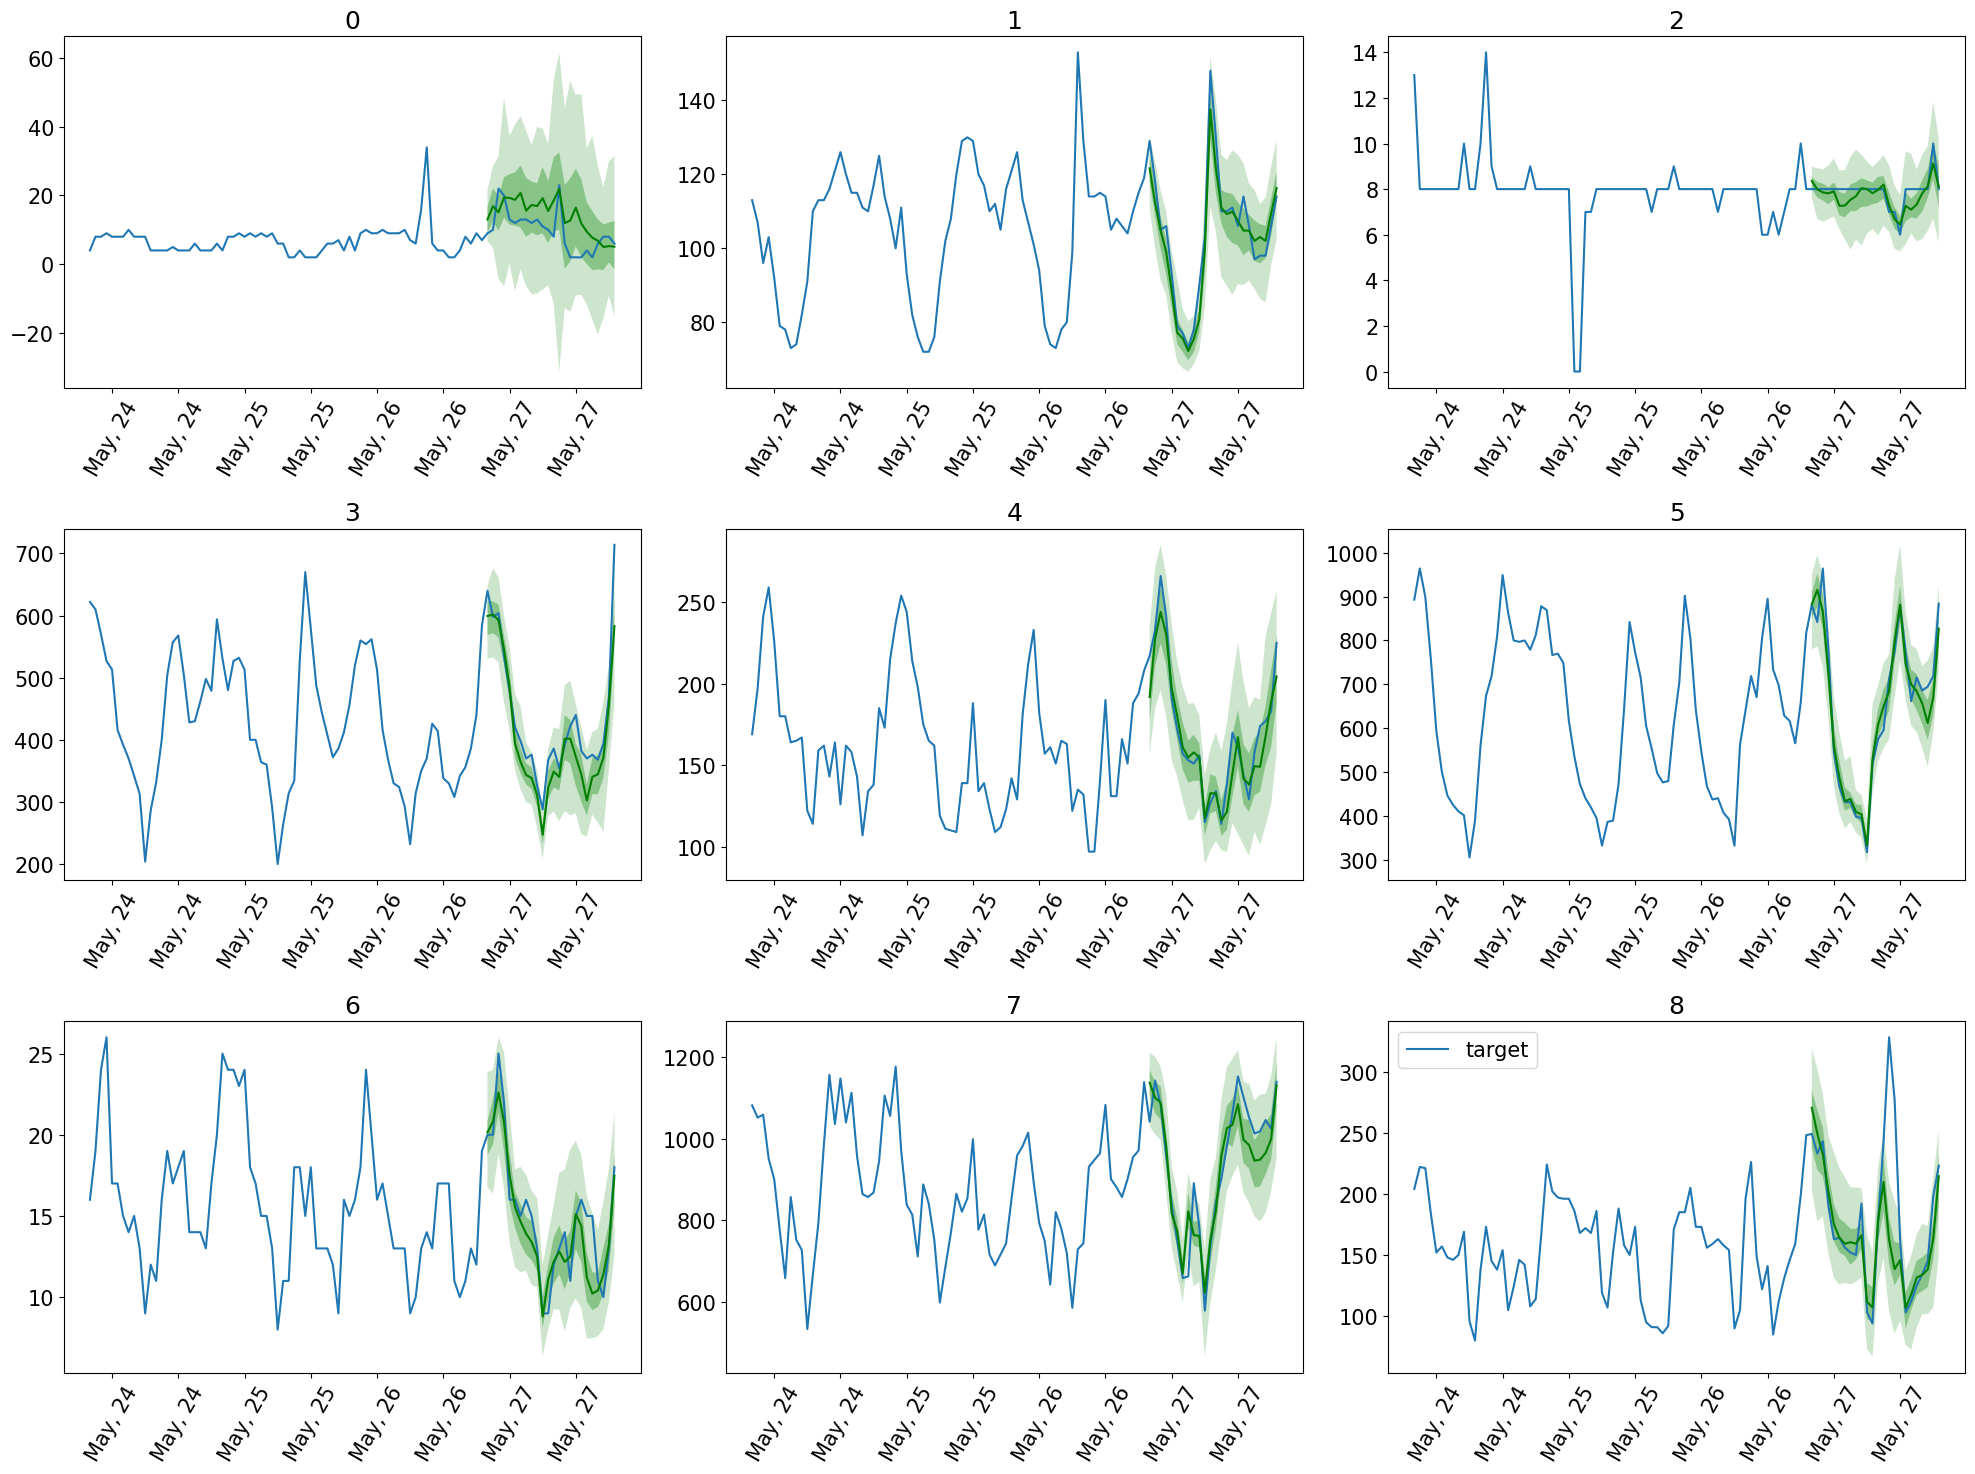

In [44]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

In [52]:
dataset.metadata.prediction_length*84

2016

In [55]:
crpss = []
for i in range(79):
    estimator = LagTransformerEstimator(
        prediction_length=dataset.metadata.prediction_length,
        context_length=dataset.metadata.prediction_length*(i+1),
        
        scaling="std",
        
        nhead=2,
        num_encoder_layers=4,
        num_decoder_layers=2,
        dim_feedforward=16,
        activation="gelu",
        
        batch_size=256,
        num_batches_per_epoch=1,
        trainer_kwargs=dict(accelerator="gpu", precision="bf16-mixed", max_epochs=1),
        ckpt_path='/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_26/checkpoints/epoch=47-step=4800.ckpt',
    )

    predictor = estimator.train(
            training_data=dataset.train,
            shuffle_buffer_length=1024,
            cache_data=True,
    )

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset.test,
        predictor=predictor,
    )

    forecasts = list(forecast_it)

    agg_metrics, _ = evaluator(iter(tss), iter(forecasts))

    
    crpss.append(agg_metrics["mean_wQuantileLoss"])

/home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/nn/modules/transformer.py:218: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because self.layers[0].norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                | Params
----------------------------------------------
0 | model | LagTransformerModel | 109 K 
----------------------------------------------
44.1 K    Tra

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 4.91649 (best 4.91649), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_28/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30871.69it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 5.88711 (best 5.88711), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_29/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 26265.91it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.04380 (best 6.04380), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_30/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 35651.85it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.32100 (best 6.32100), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_31/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28894.66it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.64016 (best 6.64016), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_32/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 27869.91it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.67477 (best 6.67477), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_33/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 31431.47it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.37866 (best 6.37866), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_34/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29173.00it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.31151 (best 6.31151), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_35/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 31094.44it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.41800 (best 6.41800), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_36/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29769.29it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.35853 (best 6.35853), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_37/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 25762.03it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.53768 (best 6.53768), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_38/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29343.40it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.26495 (best 6.26495), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_39/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 33439.90it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.80838 (best 6.80838), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_40/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 26065.77it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.63377 (best 6.63377), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_41/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29336.82it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.56645 (best 6.56645), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_42/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29684.25it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.38970 (best 6.38970), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_43/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29927.16it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.34547 (best 6.34547), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_44/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30852.99it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.93004 (best 6.93004), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_45/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28877.40it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.25691 (best 6.25691), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_46/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28099.33it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.49524 (best 6.49524), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_47/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 34435.94it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.70146 (best 6.70146), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_48/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30059.74it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.50315 (best 6.50315), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_49/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29629.19it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.71652 (best 6.71652), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_50/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29653.99it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.62966 (best 6.62966), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_51/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28298.96it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.31922 (best 6.31922), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_52/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 34931.42it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.85655 (best 6.85655), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_53/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 31414.39it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.86734 (best 6.86734), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_54/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28937.69it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.75290 (best 6.75290), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_55/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 26409.87it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.45249 (best 6.45249), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_56/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28761.25it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.78485 (best 6.78485), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_57/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 29377.79it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.78922 (best 6.78922), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_58/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30114.40it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.81056 (best 6.81056), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_59/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28539.77it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.68293 (best 6.68293), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_60/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 30099.10it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.72319 (best 6.72319), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_61/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 36479.41it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.55740 (best 6.55740), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_62/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 35858.85it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 6.78740 (best 6.78740), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_63/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28659.01it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(

Training: 0it [00:00, ?it/s]

Epoch 0, global step 1: 'train_loss' reached 7.14337 (best 7.14337), saving model to '/mnt/scratch/kashif/pytorch-transformer-ts/lag-transformer/lightning_logs/version_64/checkpoints/epoch=0-step=1.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=1` reached.
Running evaluation: 2247it [00:00, 28665.98it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
Process SpawnPoolWorker-636:
Process SpawnPoolWorker-637:
Process SpawnPoolWorker-633:
Process SpawnPoolWorker-627:
Process SpawnPoolWorker-625:
Process SpawnPoolWorker-629:
Process SpawnPoolWorker-635:
Process SpawnPoolWorker-631:
Process SpawnPoolWorker-638:
Process SpawnPoolWorker-628:
Process SpawnPoolWorker-630:
Process 

KeyboardInterrupt: 

Process SpawnPoolWorker-642:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
_pickle.UnpicklingError: invalid load key, '\x00'.


Text(0, 0.5, 'CRPS')

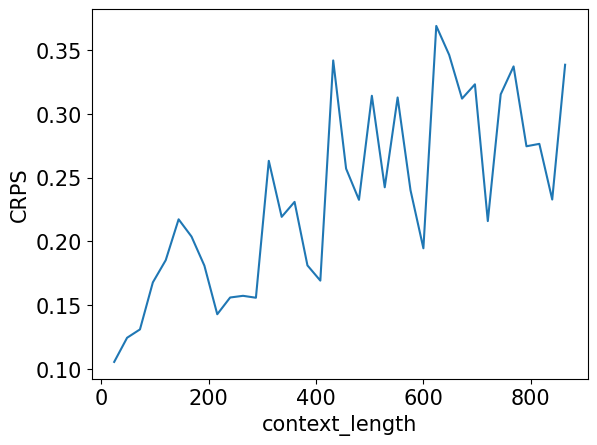

In [67]:
plt.plot([(i+1)*24 for i in range(len(crpss))], crpss)
plt.xlabel("context_length")
plt.ylabel("CRPS")